In [1]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 10.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 2.4 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.8/461.8 kB 10.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 10.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# from transformers import TrainingArguments, Trainer

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from linear_attention_transformer.linear_attention_transformer import LinearAttentionTransformer
from linear_attention_transformer.linear_attention_transformer import LinearAttentionTransformerLM

from linear_attention_transformer.autoregressive_wrapper import AutoregressiveWrapper
from linear_attention_transformer.autopadder import Autopadder
# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_pamap = "../../down_stream_dataset/adl_dataset/"
train_xyz = np.load(f"{fold_pamap}x_train.npy")
valid_xyz = np.load(f"{fold_pamap}x_valid.npy")
test_xyz = np.load(f"{fold_pamap}x_test.npy")
train_label = np.load(f"{fold_pamap}y_train.npy")
valid_label = np.load(f"{fold_pamap}y_valid.npy")
test_label = np.load(f"{fold_pamap}y_test.npy")

# データの形を確認
print(f"Train data shape: {train_xyz.shape}, Train label shape: {train_label.shape}")
print(f"Valid data shape: {valid_xyz.shape}, Valid label shape: {valid_label.shape}")
print(f"Test data shape: {test_xyz.shape}, Test label shape: {test_label.shape}")

# 各データセットを個別に標準化
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

# train_xyz の標準化
train_xyz_reshaped = train_xyz.reshape(-1, train_xyz.shape[-1])  # 2Dに変換
scaled_train_xyz = scaler_train.fit_transform(train_xyz_reshaped)  # 標準化
scaled_train_xyz = scaled_train_xyz.reshape(train_xyz.shape)  # 元の形に戻す

# valid_xyz の標準化
valid_xyz_reshaped = valid_xyz.reshape(-1, valid_xyz.shape[-1])  # 2Dに変換
scaled_valid_xyz = scaler_valid.fit_transform(valid_xyz_reshaped)  # 標準化
scaled_valid_xyz = scaled_valid_xyz.reshape(valid_xyz.shape)  # 元の形に戻す

# test_xyz の標準化
test_xyz_reshaped = test_xyz.reshape(-1, test_xyz.shape[-1])  # 2Dに変換
scaled_test_xyz = scaler_test.fit_transform(test_xyz_reshaped)  # 標準化
scaled_test_xyz = scaled_test_xyz.reshape(test_xyz.shape)  # 元の形に戻す

# 各データセットの形状を再確認
print(f"Scaled Train data shape: {scaled_train_xyz.shape}")
print(f"Scaled Valid data shape: {scaled_valid_xyz.shape}")
print(f"Scaled Test data shape: {scaled_test_xyz.shape}")

train_xyz = scaled_train_xyz
valid_xyz = scaled_valid_xyz
test_xyz = scaled_test_xyz

import torch
from torch.utils.data import Dataset, DataLoader

class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self._data = data 
        self._labels = labels  

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)
    
train_label = torch.tensor(train_label, dtype=torch.long)
test_label = torch.tensor(test_label, dtype=torch.long)
valid_label = torch.tensor(valid_label, dtype=torch.long)

train_label = train_label - train_label.min()
test_label = test_label - test_label.min()
valid_label = valid_label - valid_label.min()


train_dataset = ClassificationDataset(train_xyz, train_label)
test_dataset = ClassificationDataset(test_xyz, test_label)
valid_dataset = ClassificationDataset(valid_xyz, valid_label)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(np.unique(train_label))  # クラス数
print(num_classes)
dim = 768
depth = 8
heads = 12
dropout = 0.1

model = LinearAttentionTransformerLM(
    dim=dim,
    depth=depth,
    max_seq_len=300,
    heads=heads,
    causal=True,
)
model.to(device)

class TrainModel(nn.Module):
    def __init__(self, backbone, num_classes, d_model=768):
        super(TrainModel, self).__init__()
        self.backbone = backbone
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=8, batch_first=True)
        self.new_head = nn.Linear(d_model, num_classes)  # 分類用の出力層

    def forward(self, x):
        x = self.backbone(x)  # (batch_size, seq_len, d_model)
        attn_output, _ = self.attention(x, x, x)  # Self-Attentionを適用
        x = attn_output.mean(dim=1)  # Attentionで重み付けされた特徴を平均化
        x = self.new_head(x)  # 分類用出力
        return x

train_model = TrainModel(model, num_classes=num_classes)
train_model.to(device)

Train data shape: (406, 3, 300), Train label shape: (406,)
Valid data shape: (102, 3, 300), Valid label shape: (102,)
Test data shape: (127, 3, 300), Test label shape: (127,)
Scaled Train data shape: (406, 3, 300)
Scaled Valid data shape: (102, 3, 300)
Scaled Test data shape: (127, 3, 300)
5


TrainModel(
  (backbone): LinearAttentionTransformerLM(
    (token_emb): Linear(in_features=3, out_features=768, bias=True)
    (pos_emb): AxialPositionalEmbedding(
      (weights): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1x3x1x768 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1x1x128x768 (cuda:0)]
      )
    )
    (transformer): LinearAttentionTransformer(
      (layers): SequentialSequence(
        (layers): ModuleList(
          (0-7): 8 x ModuleList(
            (0): PreNorm(
              (fn): SelfAttention(
                (local_attn): LocalAttention(
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (to_q): Linear(in_features=768, out_features=768, bias=False)
                (to_k): Linear(in_features=768, out_features=768, bias=False)
                (to_v): Linear(in_features=768, out_features=768, bias=False)
                (to_out): Linear(in_features=768, out_features=

/tmp/ipykernel_223/451885850.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_adl.load_state_dict(torch.load(model_path, map_location=device))
/tmp/ipykernel_223/2

Test Accuracy: 83.465%

Classification Report:
              precision    recall  f1-score   support

           0      0.357     0.500     0.417        10
           1      0.958     0.920     0.939        25
           2      0.810     0.895     0.850        19
           3      0.955     0.955     0.955        22
           4      0.870     0.784     0.825        51

    accuracy                          0.835       127
   macro avg      0.790     0.811     0.797       127
weighted avg      0.852     0.835     0.841       127



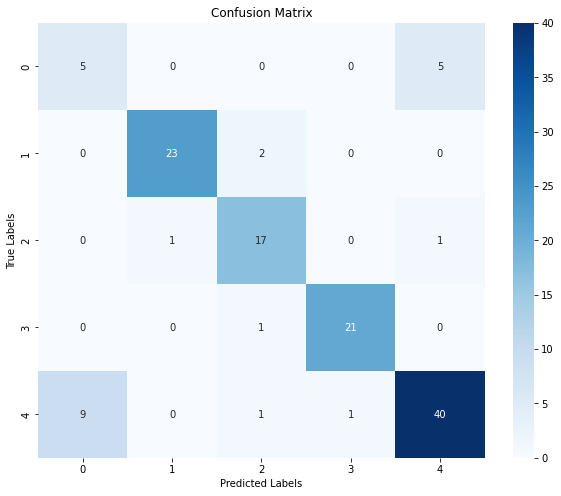

In [6]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_evaluate_model(model_class, model_path, test_loader, device):
    # モデルのインスタンスを作成 (model_adl という名前に変更)
    model_adl = model_class.to(device)
    
    # 保存済みのモデル重みをロード（weights_only=True でセキュリティ向上）
    model_adl.load_state_dict(torch.load(model_path, map_location=device))
    model_adl.eval()
    
    # モデルの評価
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)
            outputs = model_adl(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # 小数点3桁で精度表示
    test_accuracy = round(100 * test_correct / test_total, 3)
    print(f"Test Accuracy: {test_accuracy:.3f}%")

    # 分類レポートを小数点3桁で表示
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, zero_division=0, digits=3)
    print(report)

    # 混同行列の計算と表示
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, all_preds, all_labels

# モデルのパスとデバイス設定
model_path = 'path/best_model_adl_768.pth'

# モデルクラスを指定してロード＆評価（model_adl使用）
test_accuracy, test_preds, test_labels = load_and_evaluate_model(train_model, model_path, test_loader, device)


In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_pamap = "../../down_stream_dataset/oppo_dataset/"
train_xyz = np.load(f"{fold_pamap}x_train.npy")
valid_xyz = np.load(f"{fold_pamap}x_valid.npy")
test_xyz = np.load(f"{fold_pamap}x_test.npy")
train_label = np.load(f"{fold_pamap}y_train.npy")
valid_label = np.load(f"{fold_pamap}y_valid.npy")
test_label = np.load(f"{fold_pamap}y_test.npy")

# データの形を確認
print(f"Train data shape: {train_xyz.shape}, Train label shape: {train_label.shape}")
print(f"Valid data shape: {valid_xyz.shape}, Valid label shape: {valid_label.shape}")
print(f"Test data shape: {test_xyz.shape}, Test label shape: {test_label.shape}")

# 各データセットを個別に標準化
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

# train_xyz の標準化
train_xyz_reshaped = train_xyz.reshape(-1, train_xyz.shape[-1])  # 2Dに変換
scaled_train_xyz = scaler_train.fit_transform(train_xyz_reshaped)  # 標準化
scaled_train_xyz = scaled_train_xyz.reshape(train_xyz.shape)  # 元の形に戻す

# valid_xyz の標準化
valid_xyz_reshaped = valid_xyz.reshape(-1, valid_xyz.shape[-1])  # 2Dに変換
scaled_valid_xyz = scaler_valid.fit_transform(valid_xyz_reshaped)  # 標準化
scaled_valid_xyz = scaled_valid_xyz.reshape(valid_xyz.shape)  # 元の形に戻す

# test_xyz の標準化
test_xyz_reshaped = test_xyz.reshape(-1, test_xyz.shape[-1])  # 2Dに変換
scaled_test_xyz = scaler_test.fit_transform(test_xyz_reshaped)  # 標準化
scaled_test_xyz = scaled_test_xyz.reshape(test_xyz.shape)  # 元の形に戻す

# 各データセットの形状を再確認
print(f"Scaled Train data shape: {scaled_train_xyz.shape}")
print(f"Scaled Valid data shape: {scaled_valid_xyz.shape}")
print(f"Scaled Test data shape: {scaled_test_xyz.shape}")

train_xyz = scaled_train_xyz
valid_xyz = scaled_valid_xyz
test_xyz = scaled_test_xyz

import torch
from torch.utils.data import Dataset, DataLoader

class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self._data = data 
        self._labels = labels  

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)
    
train_label = torch.tensor(train_label, dtype=torch.long)
test_label = torch.tensor(test_label, dtype=torch.long)
valid_label = torch.tensor(valid_label, dtype=torch.long)

train_label = train_label - train_label.min()
test_label = test_label - test_label.min()
valid_label = valid_label - valid_label.min()


train_dataset = ClassificationDataset(train_xyz, train_label)
test_dataset = ClassificationDataset(test_xyz, test_label)
valid_dataset = ClassificationDataset(valid_xyz, valid_label)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(np.unique(train_label))  # クラス数
print(num_classes)
dim = 768
depth = 8
heads = 12
dropout = 0.1

model = LinearAttentionTransformerLM(
    dim=dim,
    depth=depth,
    max_seq_len=300,
    heads=heads,
    causal=True,
)
model.to(device)

class TrainModel(nn.Module):
    def __init__(self, backbone, num_classes, d_model=768):
        super(TrainModel, self).__init__()
        self.backbone = backbone
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=8, batch_first=True)
        self.new_head = nn.Linear(d_model, num_classes)  # 分類用の出力層

    def forward(self, x):
        x = self.backbone(x)  # (batch_size, seq_len, d_model)
        attn_output, _ = self.attention(x, x, x)  # Self-Attentionを適用
        x = attn_output.mean(dim=1)  # Attentionで重み付けされた特徴を平均化
        x = self.new_head(x)  # 分類用出力
        return x

train_model = TrainModel(model, num_classes=num_classes)
train_model.to(device)

Train data shape: (2730, 3, 300), Train label shape: (2730,)
Valid data shape: (683, 3, 300), Valid label shape: (683,)
Test data shape: (854, 3, 300), Test label shape: (854,)
Scaled Train data shape: (2730, 3, 300)
Scaled Valid data shape: (683, 3, 300)
Scaled Test data shape: (854, 3, 300)
4


TrainModel(
  (backbone): LinearAttentionTransformerLM(
    (token_emb): Linear(in_features=3, out_features=768, bias=True)
    (pos_emb): AxialPositionalEmbedding(
      (weights): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1x3x1x768 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1x1x128x768 (cuda:0)]
      )
    )
    (transformer): LinearAttentionTransformer(
      (layers): SequentialSequence(
        (layers): ModuleList(
          (0-7): 8 x ModuleList(
            (0): PreNorm(
              (fn): SelfAttention(
                (local_attn): LocalAttention(
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (to_q): Linear(in_features=768, out_features=768, bias=False)
                (to_k): Linear(in_features=768, out_features=768, bias=False)
                (to_v): Linear(in_features=768, out_features=768, bias=False)
                (to_out): Linear(in_features=768, out_features=

/tmp/ipykernel_223/1584423057.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
/tmp/ipykernel_223/28514992.py:59

Model successfully loaded with corrected keys!
Test Accuracy: 76.932%

Classification Report:
              precision    recall  f1-score   support

           0      0.817     0.803     0.810       472
           1      0.599     0.577     0.588       194
           2      0.806     0.763     0.784        38
           3      0.820     0.913     0.864       150

    accuracy                          0.769       854
   macro avg      0.760     0.764     0.761       854
weighted avg      0.767     0.769     0.768       854



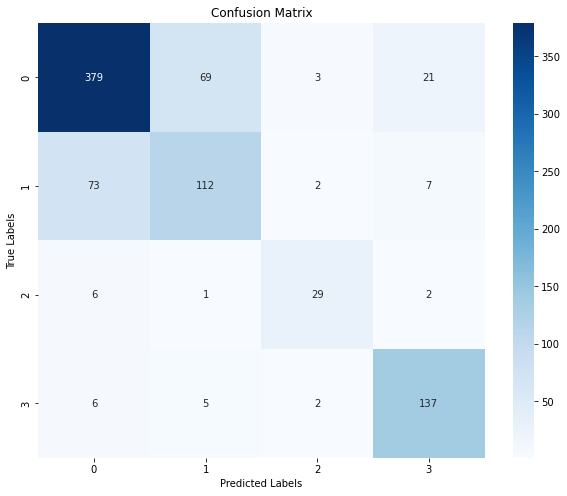

In [10]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_evaluate_model(model_class, model_path, test_loader, device):
    # モデルのインスタンスを作成
    model_adl = model_class.to(device)
    
        # モデルの重みをロード & キー変換
    checkpoint = torch.load(model_path, map_location=device)

    # Key replacement: weights_0 → weights.0 の修正
    fixed_checkpoint = {k.replace('weights_', 'weights.'): v for k, v in checkpoint.items()}

    # 修正済みの重みをロード
    model_adl.load_state_dict(fixed_checkpoint, strict=True)

    model_adl.eval()
    print("Model successfully loaded with corrected keys!")

    # モデルの評価開始
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)
            outputs = model_adl(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # 小数点以下3桁で精度計算
    test_accuracy = round(100 * test_correct / test_total, 3)
    print(f"Test Accuracy: {test_accuracy:.3f}%")

    # 分類レポートを小数点3桁で表示
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, zero_division=0, digits=3)
    print(report)

    # 混同行列の計算と可視化
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, all_preds, all_labels

# モデルのパスとデバイス設定
model_path = 'path/best_model_oppo_768.pth'

# モデルのロードと再評価の実行
test_accuracy, test_preds, test_labels = load_and_evaluate_model(train_model, model_path, test_loader, device)


In [11]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_pamap = "../../down_stream_dataset/pamap_dataset/"
train_xyz = np.load(f"{fold_pamap}x_train.npy")
valid_xyz = np.load(f"{fold_pamap}x_valid.npy")
test_xyz = np.load(f"{fold_pamap}x_test.npy")
train_label = np.load(f"{fold_pamap}y_train.npy")
valid_label = np.load(f"{fold_pamap}y_valid.npy")
test_label = np.load(f"{fold_pamap}y_test.npy")

# データの形を確認
print(f"Train data shape: {train_xyz.shape}, Train label shape: {train_label.shape}")
print(f"Valid data shape: {valid_xyz.shape}, Valid label shape: {valid_label.shape}")
print(f"Test data shape: {test_xyz.shape}, Test label shape: {test_label.shape}")

# 各データセットを個別に標準化
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

# train_xyz の標準化
train_xyz_reshaped = train_xyz.reshape(-1, train_xyz.shape[-1])  # 2Dに変換
scaled_train_xyz = scaler_train.fit_transform(train_xyz_reshaped)  # 標準化
scaled_train_xyz = scaled_train_xyz.reshape(train_xyz.shape)  # 元の形に戻す

# valid_xyz の標準化
valid_xyz_reshaped = valid_xyz.reshape(-1, valid_xyz.shape[-1])  # 2Dに変換
scaled_valid_xyz = scaler_valid.fit_transform(valid_xyz_reshaped)  # 標準化
scaled_valid_xyz = scaled_valid_xyz.reshape(valid_xyz.shape)  # 元の形に戻す

# test_xyz の標準化
test_xyz_reshaped = test_xyz.reshape(-1, test_xyz.shape[-1])  # 2Dに変換
scaled_test_xyz = scaler_test.fit_transform(test_xyz_reshaped)  # 標準化
scaled_test_xyz = scaled_test_xyz.reshape(test_xyz.shape)  # 元の形に戻す

# 各データセットの形状を再確認
print(f"Scaled Train data shape: {scaled_train_xyz.shape}")
print(f"Scaled Valid data shape: {scaled_valid_xyz.shape}")
print(f"Scaled Test data shape: {scaled_test_xyz.shape}")

train_xyz = scaled_train_xyz
valid_xyz = scaled_valid_xyz
test_xyz = scaled_test_xyz

import torch
from torch.utils.data import Dataset, DataLoader

class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self._data = data 
        self._labels = labels  

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)
    
train_label = torch.tensor(train_label, dtype=torch.long)
test_label = torch.tensor(test_label, dtype=torch.long)
valid_label = torch.tensor(valid_label, dtype=torch.long)

train_label = train_label - train_label.min()
test_label = test_label - test_label.min()
valid_label = valid_label - valid_label.min()


train_dataset = ClassificationDataset(train_xyz, train_label)
test_dataset = ClassificationDataset(test_xyz, test_label)
valid_dataset = ClassificationDataset(valid_xyz, valid_label)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(np.unique(train_label))  # クラス数
print(num_classes)
dim = 768
depth = 8
heads = 12
dropout = 0.1

model = LinearAttentionTransformerLM(
    dim=dim,
    depth=depth,
    max_seq_len=300,
    heads=heads,
    causal=True,
)
model.to(device)

class TrainModel(nn.Module):
    def __init__(self, backbone, num_classes, d_model=768):
        super(TrainModel, self).__init__()
        self.backbone = backbone
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=8, batch_first=True)
        self.new_head = nn.Linear(d_model, num_classes)  # 分類用の出力層

    def forward(self, x):
        x = self.backbone(x)  # (batch_size, seq_len, d_model)
        attn_output, _ = self.attention(x, x, x)  # Self-Attentionを適用
        x = attn_output.mean(dim=1)  # Attentionで重み付けされた特徴を平均化
        x = self.new_head(x)  # 分類用出力
        return x

train_model = TrainModel(model, num_classes=num_classes)
train_model.to(device)

Train data shape: (1836, 3, 300), Train label shape: (1836,)
Valid data shape: (459, 3, 300), Valid label shape: (459,)
Test data shape: (574, 3, 300), Test label shape: (574,)
Scaled Train data shape: (1836, 3, 300)
Scaled Valid data shape: (459, 3, 300)
Scaled Test data shape: (574, 3, 300)
8


TrainModel(
  (backbone): LinearAttentionTransformerLM(
    (token_emb): Linear(in_features=3, out_features=768, bias=True)
    (pos_emb): AxialPositionalEmbedding(
      (weights): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1x3x1x768 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1x1x128x768 (cuda:0)]
      )
    )
    (transformer): LinearAttentionTransformer(
      (layers): SequentialSequence(
        (layers): ModuleList(
          (0-7): 8 x ModuleList(
            (0): PreNorm(
              (fn): SelfAttention(
                (local_attn): LocalAttention(
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (to_q): Linear(in_features=768, out_features=768, bias=False)
                (to_k): Linear(in_features=768, out_features=768, bias=False)
                (to_v): Linear(in_features=768, out_features=768, bias=False)
                (to_out): Linear(in_features=768, out_features=

/tmp/ipykernel_223/2454911300.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Model successfully loaded with corrected keys!


/tmp/ipykernel_223/1532705314.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


Test Accuracy: 78.397%

Classification Report:
              precision    recall  f1-score   support

           0      0.926     0.852     0.888        88
           1      0.740     0.659     0.697        82
           2      0.810     0.739     0.773        69
           3      0.886     0.785     0.832        79
           4      0.545     0.873     0.671        55
           5      0.875     0.673     0.761        52
           6      0.736     0.803     0.768        66
           7      0.828     0.867     0.847        83

    accuracy                          0.784       574
   macro avg      0.793     0.781     0.780       574
weighted avg      0.803     0.784     0.787       574



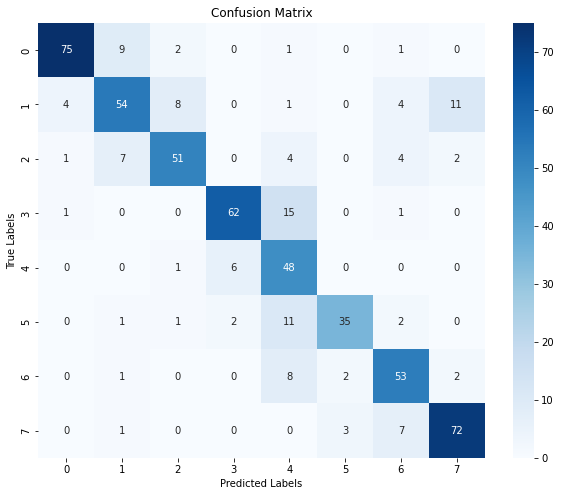

In [12]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_evaluate_model(model_class, model_path, test_loader, device):
    # モデルのインスタンスを作成
    model_adl = model_class.to(device)
    
        # モデルの重みをロード & キー変換
    checkpoint = torch.load(model_path, map_location=device)

    # Key replacement: weights_0 → weights.0 の修正
    fixed_checkpoint = {k.replace('weights_', 'weights.'): v for k, v in checkpoint.items()}

    # 修正済みの重みをロード
    model_adl.load_state_dict(fixed_checkpoint, strict=True)

    model_adl.eval()
    print("Model successfully loaded with corrected keys!")

    # モデルの評価開始
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)
            outputs = model_adl(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # 小数点以下3桁で精度計算
    test_accuracy = round(100 * test_correct / test_total, 3)
    print(f"Test Accuracy: {test_accuracy:.3f}%")

    # 分類レポートを小数点3桁で表示
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, zero_division=0, digits=3)
    print(report)

    # 混同行列の計算と可視化
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, all_preds, all_labels

# モデルのパスとデバイス設定
model_path = 'path/best_model_pamap_768.pth'

# モデルのロードと再評価の実行
test_accuracy, test_preds, test_labels = load_and_evaluate_model(train_model, model_path, test_loader, device)


In [13]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_pamap = "../../down_stream_dataset/realworld_dataset/"
train_xyz = np.load(f"{fold_pamap}x_train.npy")
valid_xyz = np.load(f"{fold_pamap}x_valid.npy")
test_xyz = np.load(f"{fold_pamap}x_test.npy")
train_label = np.load(f"{fold_pamap}y_train.npy")
valid_label = np.load(f"{fold_pamap}y_valid.npy")
test_label = np.load(f"{fold_pamap}y_test.npy")

# データの形を確認
print(f"Train data shape: {train_xyz.shape}, Train label shape: {train_label.shape}")
print(f"Valid data shape: {valid_xyz.shape}, Valid label shape: {valid_label.shape}")
print(f"Test data shape: {test_xyz.shape}, Test label shape: {test_label.shape}")

# 各データセットを個別に標準化
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

# train_xyz の標準化
train_xyz_reshaped = train_xyz.reshape(-1, train_xyz.shape[-1])  # 2Dに変換
scaled_train_xyz = scaler_train.fit_transform(train_xyz_reshaped)  # 標準化
scaled_train_xyz = scaled_train_xyz.reshape(train_xyz.shape)  # 元の形に戻す

# valid_xyz の標準化
valid_xyz_reshaped = valid_xyz.reshape(-1, valid_xyz.shape[-1])  # 2Dに変換
scaled_valid_xyz = scaler_valid.fit_transform(valid_xyz_reshaped)  # 標準化
scaled_valid_xyz = scaled_valid_xyz.reshape(valid_xyz.shape)  # 元の形に戻す

# test_xyz の標準化
test_xyz_reshaped = test_xyz.reshape(-1, test_xyz.shape[-1])  # 2Dに変換
scaled_test_xyz = scaler_test.fit_transform(test_xyz_reshaped)  # 標準化
scaled_test_xyz = scaled_test_xyz.reshape(test_xyz.shape)  # 元の形に戻す

# 各データセットの形状を再確認
print(f"Scaled Train data shape: {scaled_train_xyz.shape}")
print(f"Scaled Valid data shape: {scaled_valid_xyz.shape}")
print(f"Scaled Test data shape: {scaled_test_xyz.shape}")

train_xyz = scaled_train_xyz
valid_xyz = scaled_valid_xyz
test_xyz = scaled_test_xyz

import torch
from torch.utils.data import Dataset, DataLoader

class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self._data = data 
        self._labels = labels  

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)
    
train_label = torch.tensor(train_label, dtype=torch.long)
test_label = torch.tensor(test_label, dtype=torch.long)
valid_label = torch.tensor(valid_label, dtype=torch.long)

train_label = train_label - train_label.min()
test_label = test_label - test_label.min()
valid_label = valid_label - valid_label.min()


train_dataset = ClassificationDataset(train_xyz, train_label)
test_dataset = ClassificationDataset(test_xyz, test_label)
valid_dataset = ClassificationDataset(valid_xyz, valid_label)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(np.unique(train_label))  # クラス数
print(num_classes)
dim = 768
depth = 8
heads = 12
dropout = 0.1

model = LinearAttentionTransformerLM(
    dim=dim,
    depth=depth,
    max_seq_len=300,
    heads=heads,
    causal=True,
)
model.to(device)

class TrainModel(nn.Module):
    def __init__(self, backbone, num_classes, d_model=768):
        super(TrainModel, self).__init__()
        self.backbone = backbone
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=8, batch_first=True)
        self.new_head = nn.Linear(d_model, num_classes)  # 分類用の出力層

    def forward(self, x):
        x = self.backbone(x)  # (batch_size, seq_len, d_model)
        attn_output, _ = self.attention(x, x, x)  # Self-Attentionを適用
        x = attn_output.mean(dim=1)  # Attentionで重み付けされた特徴を平均化
        x = self.new_head(x)  # 分類用出力
        return x

train_model = TrainModel(model, num_classes=num_classes)
train_model.to(device)

Train data shape: (7964, 3, 300), Train label shape: (7964,)
Valid data shape: (1992, 3, 300), Valid label shape: (1992,)
Test data shape: (2490, 3, 300), Test label shape: (2490,)
Scaled Train data shape: (7964, 3, 300)
Scaled Valid data shape: (1992, 3, 300)
Scaled Test data shape: (2490, 3, 300)
8


TrainModel(
  (backbone): LinearAttentionTransformerLM(
    (token_emb): Linear(in_features=3, out_features=768, bias=True)
    (pos_emb): AxialPositionalEmbedding(
      (weights): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1x3x1x768 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1x1x128x768 (cuda:0)]
      )
    )
    (transformer): LinearAttentionTransformer(
      (layers): SequentialSequence(
        (layers): ModuleList(
          (0-7): 8 x ModuleList(
            (0): PreNorm(
              (fn): SelfAttention(
                (local_attn): LocalAttention(
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (to_q): Linear(in_features=768, out_features=768, bias=False)
                (to_k): Linear(in_features=768, out_features=768, bias=False)
                (to_v): Linear(in_features=768, out_features=768, bias=False)
                (to_out): Linear(in_features=768, out_features=

/tmp/ipykernel_223/3357249833.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Model successfully loaded with corrected keys!


/tmp/ipykernel_223/1567923358.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


Test Accuracy: 89.679%

Classification Report:
              precision    recall  f1-score   support

           0      0.929     0.929     0.929       268
           1      0.894     0.909     0.901       351
           2      1.000     1.000     1.000        46
           3      0.910     0.936     0.923       357
           4      0.933     0.892     0.912       390
           5      0.847     0.845     0.846       348
           6      0.797     0.860     0.827       351
           7      0.966     0.900     0.932       379

    accuracy                          0.897      2490
   macro avg      0.909     0.909     0.909      2490
weighted avg      0.899     0.897     0.897      2490



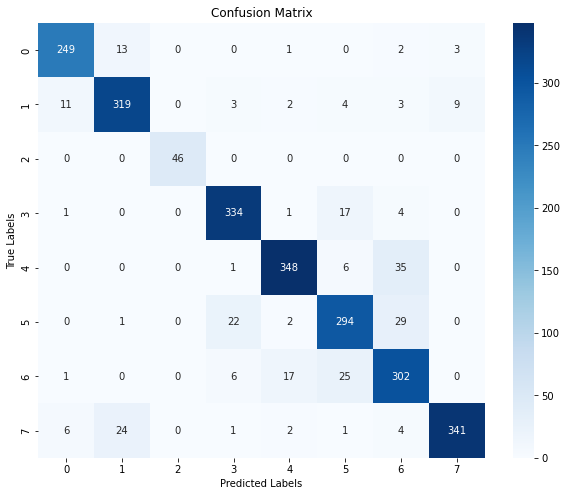

In [14]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_evaluate_model(model_class, model_path, test_loader, device):
    # モデルのインスタンスを作成
    model_adl = model_class.to(device)
    
        # モデルの重みをロード & キー変換
    checkpoint = torch.load(model_path, map_location=device)

    # Key replacement: weights_0 → weights.0 の修正
    fixed_checkpoint = {k.replace('weights_', 'weights.'): v for k, v in checkpoint.items()}

    # 修正済みの重みをロード
    model_adl.load_state_dict(fixed_checkpoint, strict=True)

    model_adl.eval()
    print("Model successfully loaded with corrected keys!")

    # モデルの評価開始
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)
            outputs = model_adl(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # 小数点以下3桁で精度計算
    test_accuracy = round(100 * test_correct / test_total, 3)
    print(f"Test Accuracy: {test_accuracy:.3f}%")

    # 分類レポートを小数点3桁で表示
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, zero_division=0, digits=3)
    print(report)

    # 混同行列の計算と可視化
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, all_preds, all_labels

# モデルのパスとデバイス設定
model_path = 'path/best_model_realworld_768.pth'

# モデルのロードと再評価の実行
test_accuracy, test_preds, test_labels = load_and_evaluate_model(train_model, model_path, test_loader, device)


In [15]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_pamap = "../../down_stream_dataset/wisdm_dataset/"
train_xyz = np.load(f"{fold_pamap}x_train.npy")
valid_xyz = np.load(f"{fold_pamap}x_valid.npy")
test_xyz = np.load(f"{fold_pamap}x_test.npy")
train_label = np.load(f"{fold_pamap}y_train.npy")
valid_label = np.load(f"{fold_pamap}y_valid.npy")
test_label = np.load(f"{fold_pamap}y_test.npy")

# データの形を確認
print(f"Train data shape: {train_xyz.shape}, Train label shape: {train_label.shape}")
print(f"Valid data shape: {valid_xyz.shape}, Valid label shape: {valid_label.shape}")
print(f"Test data shape: {test_xyz.shape}, Test label shape: {test_label.shape}")

# 各データセットを個別に標準化
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

# train_xyz の標準化
train_xyz_reshaped = train_xyz.reshape(-1, train_xyz.shape[-1])  # 2Dに変換
scaled_train_xyz = scaler_train.fit_transform(train_xyz_reshaped)  # 標準化
scaled_train_xyz = scaled_train_xyz.reshape(train_xyz.shape)  # 元の形に戻す

# valid_xyz の標準化
valid_xyz_reshaped = valid_xyz.reshape(-1, valid_xyz.shape[-1])  # 2Dに変換
scaled_valid_xyz = scaler_valid.fit_transform(valid_xyz_reshaped)  # 標準化
scaled_valid_xyz = scaled_valid_xyz.reshape(valid_xyz.shape)  # 元の形に戻す

# test_xyz の標準化
test_xyz_reshaped = test_xyz.reshape(-1, test_xyz.shape[-1])  # 2Dに変換
scaled_test_xyz = scaler_test.fit_transform(test_xyz_reshaped)  # 標準化
scaled_test_xyz = scaled_test_xyz.reshape(test_xyz.shape)  # 元の形に戻す

# 各データセットの形状を再確認
print(f"Scaled Train data shape: {scaled_train_xyz.shape}")
print(f"Scaled Valid data shape: {scaled_valid_xyz.shape}")
print(f"Scaled Test data shape: {scaled_test_xyz.shape}")

train_xyz = scaled_train_xyz
valid_xyz = scaled_valid_xyz
test_xyz = scaled_test_xyz

import torch
from torch.utils.data import Dataset, DataLoader

class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self._data = data 
        self._labels = labels  

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)
    
train_label = torch.tensor(train_label, dtype=torch.long)
test_label = torch.tensor(test_label, dtype=torch.long)
valid_label = torch.tensor(valid_label, dtype=torch.long)

train_label = train_label - train_label.min()
test_label = test_label - test_label.min()
valid_label = valid_label - valid_label.min()


train_dataset = ClassificationDataset(train_xyz, train_label)
test_dataset = ClassificationDataset(test_xyz, test_label)
valid_dataset = ClassificationDataset(valid_xyz, valid_label)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(np.unique(train_label))  # クラス数
print(num_classes)
dim = 768
depth = 8
heads = 12
dropout = 0.1

model = LinearAttentionTransformerLM(
    dim=dim,
    depth=depth,
    max_seq_len=300,
    heads=heads,
    causal=True,
)
model.to(device)

class TrainModel(nn.Module):
    def __init__(self, backbone, num_classes, d_model=768):
        super(TrainModel, self).__init__()
        self.backbone = backbone
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=8, batch_first=True)
        self.new_head = nn.Linear(d_model, num_classes)  # 分類用の出力層

    def forward(self, x):
        x = self.backbone(x)  # (batch_size, seq_len, d_model)
        attn_output, _ = self.attention(x, x, x)  # Self-Attentionを適用
        x = attn_output.mean(dim=1)  # Attentionで重み付けされた特徴を平均化
        x = self.new_head(x)  # 分類用出力
        return x

train_model = TrainModel(model, num_classes=num_classes)
train_model.to(device)

Train data shape: (17916, 3, 300), Train label shape: (17916,)
Valid data shape: (4480, 3, 300), Valid label shape: (4480,)
Test data shape: (5600, 3, 300), Test label shape: (5600,)
Scaled Train data shape: (17916, 3, 300)
Scaled Valid data shape: (4480, 3, 300)
Scaled Test data shape: (5600, 3, 300)
18


TrainModel(
  (backbone): LinearAttentionTransformerLM(
    (token_emb): Linear(in_features=3, out_features=768, bias=True)
    (pos_emb): AxialPositionalEmbedding(
      (weights): ParameterList(
          (0): Parameter containing: [torch.float32 of size 1x3x1x768 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 1x1x128x768 (cuda:0)]
      )
    )
    (transformer): LinearAttentionTransformer(
      (layers): SequentialSequence(
        (layers): ModuleList(
          (0-7): 8 x ModuleList(
            (0): PreNorm(
              (fn): SelfAttention(
                (local_attn): LocalAttention(
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (to_q): Linear(in_features=768, out_features=768, bias=False)
                (to_k): Linear(in_features=768, out_features=768, bias=False)
                (to_v): Linear(in_features=768, out_features=768, bias=False)
                (to_out): Linear(in_features=768, out_features=

/tmp/ipykernel_223/798593309.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Model successfully loaded with corrected keys!


/tmp/ipykernel_223/2061324441.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


Test Accuracy: 87.732%

Classification Report:
              precision    recall  f1-score   support

           0      0.948     0.973     0.961       300
           1      0.784     0.703     0.741       320
           2      0.994     0.979     0.986       332
           3      0.977     0.997     0.987       337
           4      0.731     0.805     0.766       307
           5      0.888     0.947     0.916       318
           6      0.981     1.000     0.990       310
           7      0.960     0.866     0.911       306
           8      0.839     0.812     0.825       308
           9      0.626     0.602     0.614       322
          10      0.770     0.838     0.802       308
          11      0.882     0.836     0.858       286
          12      0.891     0.873     0.882       291
          13      0.895     0.868     0.882       296
          14      0.962     0.935     0.948       352
          15      0.916     0.899     0.907       326
          16      0.875     0.960 

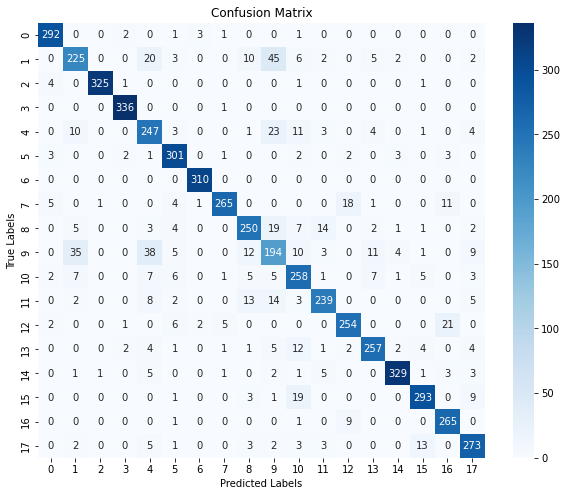

In [16]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_evaluate_model(model_class, model_path, test_loader, device):
    # モデルのインスタンスを作成
    model_adl = model_class.to(device)
    
        # モデルの重みをロード & キー変換
    checkpoint = torch.load(model_path, map_location=device)

    # Key replacement: weights_0 → weights.0 の修正
    fixed_checkpoint = {k.replace('weights_', 'weights.'): v for k, v in checkpoint.items()}

    # 修正済みの重みをロード
    model_adl.load_state_dict(fixed_checkpoint, strict=True)

    model_adl.eval()
    print("Model successfully loaded with corrected keys!")

    # モデルの評価開始
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)
            outputs = model_adl(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # 小数点以下3桁で精度計算
    test_accuracy = round(100 * test_correct / test_total, 3)
    print(f"Test Accuracy: {test_accuracy:.3f}%")

    # 分類レポートを小数点3桁で表示
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, zero_division=0, digits=3)
    print(report)

    # 混同行列の計算と可視化
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, all_preds, all_labels

# モデルのパスとデバイス設定
model_path = 'path/best_model_wisdm_768.pth'

# モデルのロードと再評価の実行
test_accuracy, test_preds, test_labels = load_and_evaluate_model(train_model, model_path, test_loader, device)
